In [164]:
import numpy as np
import pandas as pd
import requests
from io import StringIO
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
import nltk
from nltk.corpus import stopwords
import re
from tqdm import tqdm_notebook
from nltk.corpus import stopwords
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

import pandas as pd
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [165]:
df = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
df.shape

(256442, 6)

In [166]:
df=df.loc[0:1000,:]

In [167]:
df.isna().sum()

id           0
tid1         0
tid2         0
title1_en    0
title2_en    0
label        0
dtype: int64

In [168]:
df.shape

(1001, 6)

In [169]:
df.head()

,id,tid1,tid2,title1_en,title2_en,label
0,195611,0,1,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,191474,2,3,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
2,25300,2,4,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated
3,123757,2,8,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP overtakes Hong Kong? Bureau of ...,unrelated
4,141761,2,11,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outpaces Hong Kong? Defending R...,unrelated


In [170]:
sum(df['label']=='unrelated')

627

In [171]:
sum(df['label']=='agreed')

339

In [172]:
sum(df['label']=='disagreed')

35

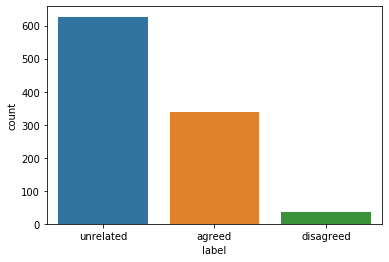

In [173]:
import seaborn as sns
sns.countplot(df.label)

In [174]:
df['text'] = df['title1_en'] + " " + df['title2_en']

In [175]:
#labels = df['label'].astype('category').cat.categories.tolist()
#replace_map_comp = {'label' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
#print(replace_map_comp)

In [176]:
#df.replace(replace_map_comp, inplace=True)

In [177]:
#df.head(10)

In [178]:
#df=df.drop(['title2_en','title1_en','tid1','tid2','id'],axis=1)

In [179]:
#df.head(10)

In [180]:
labels = df['label'].astype('category').cat.categories.tolist()
replace_map_comp = {'label' : {k: v for k,v in zip(labels,list(range(0,len(labels)+1)))}}
print(replace_map_comp)

{'label': {'agreed': 0, 'disagreed': 1, 'unrelated': 2}}


In [181]:
df.replace(replace_map_comp, inplace=True)

In [182]:
x=df.drop('label',axis=1)

In [183]:
x=df['text']

In [184]:
x.head()

0    There are two new old-age insurance benefits f...
1    "If you do not come to Shenzhen, sooner or lat...
2    "If you do not come to Shenzhen, sooner or lat...
3    "If you do not come to Shenzhen, sooner or lat...
4    "If you do not come to Shenzhen, sooner or lat...
Name: text, dtype: object

In [185]:
#y=pd.get_dummies(df['label'])

In [186]:
y=df['label']

In [187]:
y.head()

0    2
1    2
2    2
3    2
4    2
Name: label, dtype: int64

In [188]:
y.head()

0    2
1    2
2    2
3    2
4    2
Name: label, dtype: int64

In [189]:
voc_size=5000

In [190]:
messages=x.copy()

In [191]:
messages[0]

'There are two new old-age insurance benefits for old people in rural areas. Have you got them? Police disprove "bird\'s nest congress each person gets 50,000 yuan" still old people insist on going to beijing'

In [192]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [193]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    print(i)
    review = re.sub('[^a-zA-Z]', ' ', df['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in
             stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [194]:
corpus[1]

'come shenzhen sooner later son also come less year shenzhen per capita gdp exceed hong kong shenzhen gdp outstrip hong kong shenzhen statist bureau dismiss rumor gap narrow'

In [195]:
corpus

['two new old age insur benefit old peopl rural area got polic disprov bird nest congress person get yuan still old peopl insist go beij',
 'come shenzhen sooner later son also come less year shenzhen per capita gdp exceed hong kong shenzhen gdp outstrip hong kong shenzhen statist bureau dismiss rumor gap narrow',
 'come shenzhen sooner later son also come less year shenzhen per capita gdp exceed hong kong gdp overtop hong kong shenzhen clarifi littl bit',
 'come shenzhen sooner later son also come less year shenzhen per capita gdp exceed hong kong shenzhen gdp overtak hong kong bureau statist refut rumor unsurpass gap shrink',
 'come shenzhen sooner later son also come less year shenzhen per capita gdp exceed hong kong shenzhen gdp outpac hong kong defend rumor gap narrow yet',
 'discrimin oil gutter oil mean garlic practic use singl piec garlic distinguish oil oil',
 'discrimin oil gutter oil mean garlic differenti gutter oil identifi singl piec garlic',
 'discrimin oil gutter oil me

In [196]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 
onehot_repr

[[3978,
  4839,
  1362,
  3117,
  940,
  994,
  1362,
  2121,
  3961,
  3117,
  3791,
  1949,
  3938,
  3172,
  1799,
  329,
  3065,
  2342,
  2027,
  876,
  1362,
  2121,
  234,
  730,
  1416],
 [2383,
  4252,
  2991,
  98,
  4981,
  556,
  2383,
  2484,
  4894,
  4252,
  861,
  3717,
  4127,
  4424,
  1218,
  1045,
  4252,
  4127,
  4508,
  1218,
  1045,
  4252,
  1484,
  415,
  958,
  3246,
  4196,
  2031],
 [2383,
  4252,
  2991,
  98,
  4981,
  556,
  2383,
  2484,
  4894,
  4252,
  861,
  3717,
  4127,
  4424,
  1218,
  1045,
  4127,
  4345,
  1218,
  1045,
  4252,
  1472,
  2586,
  2887],
 [2383,
  4252,
  2991,
  98,
  4981,
  556,
  2383,
  2484,
  4894,
  4252,
  861,
  3717,
  4127,
  4424,
  1218,
  1045,
  4252,
  4127,
  4344,
  1218,
  1045,
  415,
  1484,
  4957,
  3246,
  1954,
  4196,
  2814],
 [2383,
  4252,
  2991,
  98,
  4981,
  556,
  2383,
  2484,
  4894,
  4252,
  861,
  3717,
  4127,
  4424,
  1218,
  1045,
  4252,
  4127,
  3011,
  1218,
  1045,
  3567,
  324

In [197]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[ 994 1362 2121 ...  234  730 1416]
 [4894 4252  861 ... 3246 4196 2031]
 [4981  556 2383 ... 1472 2586 2887]
 ...
 [4174 4619 2724 ... 2984 2966 2899]
 [1583 4485 1343 ... 4834 2424   78]
 [2056 4174 4619 ... 2172 3027 2585]]


In [198]:
embedded_docs[0]


array([ 994, 1362, 2121, 3961, 3117, 3791, 1949, 3938, 3172, 1799,  329,
       3065, 2342, 2027,  876, 1362, 2121,  234,  730, 1416])

In [199]:
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length= sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 40)            200000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [200]:
len(embedded_docs),y.shape

(1001, (1001,))

In [201]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)
X_final.shape,y_final.shape

((1001, 20), (1001,))

In [202]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

In [ ]:
from tensorflow.keras.layers import Dropout
## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
y_pred=model.predict_classes(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

In [ ]:
y_pred

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,y_pred)
